In [1]:
import os, random, shutil
from pathlib import Path
import cv2
import numpy as np

!pip install mtcnn opencv-python

from mtcnn import MTCNN
from google.colab import drive

drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 91.1 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
RAW_DIR = Path("/content/drive/MyDrive/final data/Final_data_raw")

EXP_DIR = Path("/content/drive/MyDrive/AI_Project/experiment")
ALIGNED_DIR = EXP_DIR / "aligned_224"
SPLIT_DIR   = EXP_DIR / "split"

TRAIN_DIR = SPLIT_DIR / "train"
VAL_DIR   = SPLIT_DIR / "val"
TEST_DIR  = SPLIT_DIR / "test"

for d in [ALIGNED_DIR, TRAIN_DIR, VAL_DIR, TEST_DIR]:
    d.mkdir(parents=True, exist_ok=True)

In [3]:
IMG_SIZE = 224
MAX_CLASSES = 30
MAX_IMAGES_PER_CLASS = 200
MIN_IMAGES_AFTER_ALIGNMENT = 120   # مهم جدًا

In [4]:
detector = MTCNN()

# اختيار الأشخاص بشكل ثابت
persons = sorted([p for p in RAW_DIR.iterdir() if p.is_dir()])
persons = persons[:MAX_CLASSES]

print("Target classes:", len(persons))

for person_folder in persons:
    person_out = ALIGNED_DIR / person_folder.name
    person_out.mkdir(parents=True, exist_ok=True)  # 🔴 الحل هنا

    images = list(person_folder.glob("*"))[:MAX_IMAGES_PER_CLASS]

    for img_path in images:
        img = cv2.imread(str(img_path))
        if img is None:
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        faces = detector.detect_faces(img_rgb)
        if len(faces) == 0:
            continue

        face = max(faces, key=lambda f: f['box'][2] * f['box'][3])
        x, y, w, h = face['box']
        x, y = max(0, x), max(0, y)

        face_img = img[y:y+h, x:x+w]
        if face_img.size == 0:
            continue

        face_img = cv2.resize(face_img, (IMG_SIZE, IMG_SIZE))
        cv2.imwrite(str(person_out / img_path.name), face_img)

print("✅ Face alignment finished")

Target classes: 30
✅ Face alignment finished


In [5]:
valid_persons = []

for person in sorted(ALIGNED_DIR.iterdir()):
    if not person.is_dir():
        continue

    images = list(person.glob("*"))
    if len(images) >= MIN_IMAGES_AFTER_ALIGNMENT:
        valid_persons.append(person)

print("Valid classes after alignment:", len(valid_persons))

Valid classes after alignment: 30


In [6]:
random.seed(42)

for person in valid_persons:
    images = list(person.glob("*"))
    random.shuffle(images)

    n = len(images)
    n_train = int(0.7 * n)
    n_val   = int(0.1 * n)

    train_imgs = images[:n_train]
    val_imgs   = images[n_train:n_train+n_val]
    test_imgs  = images[n_train+n_val:]

    for split_dir, imgs in zip(
        [TRAIN_DIR, VAL_DIR, TEST_DIR],
        [train_imgs, val_imgs, test_imgs]
    ):
        dest = split_dir / person.name
        dest.mkdir(parents=True, exist_ok=True)

        for img in imgs:
            shutil.copy2(img, dest / img.name)

print("✅ Split 70/20/10 completed")


✅ Split 70/20/10 completed


In [17]:
print("Train classes:", len(list(TRAIN_DIR.iterdir())))
print("Val classes:", len(list(VAL_DIR.iterdir())))
print("Test classes:", len(list(TEST_DIR.iterdir())))

Train classes: 30
Val classes: 30
Test classes: 30


In [15]:
# =========================
# FINAL FINAL SCRIPT (NO MORE HEADACHE):
# VGG16 + Strong Aug + Auto GPU/CPU + Train if Not Exists + Save in Drive
# + AMP (new API) + AdamW + Label Smoothing + Scheduler + EarlyStopping
# =========================

from google.colab import drive
drive.mount('/content/drive')

import json
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

# -------------------------
# 1) CONFIG
# -------------------------
DATA_DIR  = Path("/content/drive/MyDrive/AI_Project/experiment/split")
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR   = DATA_DIR / "val"

NUM_CLASSES = 30
IMG_SIZE = 224

TOTAL_EPOCHS = 30
EPOCHS_HEAD = 10
EPOCHS_FT   = TOTAL_EPOCHS - EPOCHS_HEAD  # 20

LR_HEAD = 1e-3
LR_FT   = 2e-5   # شوية أعلى من 1e-5 عشان FT يفيد
WEIGHT_DECAY = 1e-4

PATIENCE = 5  # early stopping

SAVE_DIR = Path("/content/drive/MyDrive/AI_Project/trained_models")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

BEST_MODEL_PATH = SAVE_DIR / "vgg16_best.pth"
LABELS_PATH     = SAVE_DIR / "class_to_idx.json"

# ✅ Auto GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PIN_MEMORY = (device.type == "cuda")
WORKERS = 2 if device.type == "cuda" else 0
BATCH_SIZE = 32 if device.type == "cuda" else 8

USE_AMP = (device.type == "cuda")
scaler = torch.amp.GradScaler(device="cuda", enabled=USE_AMP)

print("Device:", device)
print("Train dir:", TRAIN_DIR)
print("Val dir  :", VAL_DIR)
print("Save dir :", SAVE_DIR)
print("Batch size:", BATCH_SIZE, "| Workers:", WORKERS, "| Pin_memory:", PIN_MEMORY, "| AMP:", USE_AMP)

# -------------------------
# 2) AUGMENTATION (strong + stable, no fog/sunflare warnings)
# -------------------------
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_aug = A.Compose([
    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.65, 1.0), ratio=(0.75, 1.33), p=1.0),
    A.HorizontalFlip(p=0.5),

    A.Affine(
        translate_percent=(-0.05, 0.05),
        scale=(0.85, 1.15),
        rotate=(-15, 15),
        shear=(-7, 7),
        p=0.7
    ),
    A.Perspective(scale=(0.02, 0.06), p=0.2),

    A.OneOf([
        A.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.20, hue=0.02, p=1.0),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
        A.HueSaturationValue(hue_shift_limit=8, sat_shift_limit=15, val_shift_limit=10, p=1.0),
    ], p=0.8),

    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 5), p=1.0),
        A.MotionBlur(blur_limit=5, p=1.0),
        A.GaussNoise(std_range=(0.02, 0.07), p=1.0),
        A.ImageCompression(quality_range=(60, 95), p=1.0),
        A.Sharpen(alpha=(0.1, 0.25), lightness=(0.8, 1.2), p=1.0),
    ], p=0.35),

    A.CoarseDropout(
        num_holes_range=(1, 2),
        hole_height_range=(20, 60),
        hole_width_range=(20, 60),
        fill=0,
        p=0.30
    ),

    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD, max_pixel_value=255.0),
    ToTensorV2(),
])

val_aug = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD, max_pixel_value=255.0),
    ToTensorV2(),
])

# -------------------------
# 3) DATASET
# -------------------------
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def build_index(root_dir: Path):
    if not root_dir.exists():
        raise FileNotFoundError(f"Folder not found: {root_dir}")

    classes = sorted([d.name for d in root_dir.iterdir() if d.is_dir()])
    class_to_idx = {c: i for i, c in enumerate(classes)}

    items = []
    for c in classes:
        for p in (root_dir / c).rglob("*"):
            if p.suffix.lower() in IMG_EXTS:
                items.append((str(p), class_to_idx[c]))
    return items, class_to_idx

class FolderDataset(Dataset):
    def __init__(self, items, transform):
        self.items = items
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, y = self.items[idx]
        img = Image.open(path).convert("RGB")
        img = np.array(img)
        x = self.transform(image=img)["image"]
        return x, y

train_items, class_to_idx = build_index(TRAIN_DIR)
val_items, _ = build_index(VAL_DIR)

assert len(class_to_idx) == NUM_CLASSES, f"Expected {NUM_CLASSES} classes, got {len(class_to_idx)}"

with open(LABELS_PATH, "w", encoding="utf-8") as f:
    json.dump(class_to_idx, f, ensure_ascii=False, indent=2)

train_ds = FolderDataset(train_items, transform=train_aug)
val_ds   = FolderDataset(val_items, transform=val_aug)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=WORKERS, pin_memory=PIN_MEMORY)

print("Train images:", len(train_ds), "| Val images:", len(val_ds))

# -------------------------
# 4) MODEL + HELPERS
# -------------------------
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, NUM_CLASSES)
model = model.to(device)

# ✅ Label smoothing helps multi-class generalization
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

def set_features_trainable(m, trainable: bool):
    for p in m.features.parameters():
        p.requires_grad = trainable

@torch.no_grad()
def evaluate(m, loader):
    m.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = m(x)
        loss = criterion(logits, y)
        loss_sum += loss.item() * y.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total

def train_one_epoch(m, loader, optimizer):
    m.train()
    total, correct, loss_sum = 0, 0, 0.0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device.type, enabled=USE_AMP):
            logits = m(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loss_sum += loss.item() * y.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return loss_sum / total, correct / total

# -------------------------
# 5) IF MODEL EXISTS -> LOAD, ELSE TRAIN + SAVE
# -------------------------
if BEST_MODEL_PATH.exists():
    print("\n✅ Model exists → loading and skipping training")
    model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
    model.eval()

else:
    print("\nℹ️ Model not found → training now...")

    best_acc = 0.0

    # ===== Phase A: Train head =====
    print("\n== Phase A: Train classifier head ==")
    set_features_trainable(model, False)

    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                            lr=LR_HEAD, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

    bad_epochs = 0
    for epoch in range(1, EPOCHS_HEAD + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer)
        va_loss, va_acc = evaluate(model, val_loader)
        scheduler.step(va_acc)

        print(f"[Head] {epoch:02d}/{EPOCHS_HEAD} | "
              f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
              f"val loss {va_loss:.4f} acc {va_acc:.4f}")

        if va_acc > best_acc:
            best_acc = va_acc
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            bad_epochs = 0
            print(f"  ✅ Saved best (val acc={best_acc:.4f})")
        else:
            bad_epochs += 1

        if bad_epochs >= PATIENCE:
            print("⏹️ Early stopping in HEAD phase")
            break

    # ===== Phase B: Fine-tune (unfreeze more) =====
    print("\n== Phase B: Fine-tune ==")
    set_features_trainable(model, False)
    for p in model.features[17:].parameters():  # ✅ أوسع من قبل
        p.requires_grad = True

    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                            lr=LR_FT, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

    bad_epochs = 0
    for epoch in range(1, EPOCHS_FT + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer)
        va_loss, va_acc = evaluate(model, val_loader)
        scheduler.step(va_acc)

        print(f"[FT]   {epoch:02d}/{EPOCHS_FT} | "
              f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
              f"val loss {va_loss:.4f} acc {va_acc:.4f}")

        if va_acc > best_acc:
            best_acc = va_acc
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            bad_epochs = 0
            print(f"  ✅ Saved best (val acc={best_acc:.4f})")
        else:
            bad_epochs += 1

        if bad_epochs >= PATIENCE:
            print("⏹️ Early stopping in FT phase")
            break

    print("\n✅ Training finished. Best val acc:", best_acc)

# Load best into memory at the end
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model.eval()
print("\n✅ Ready. Loaded best model from:", BEST_MODEL_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda
Train dir: /content/drive/MyDrive/AI_Project/experiment/split/train
Val dir  : /content/drive/MyDrive/AI_Project/experiment/split/val
Save dir : /content/drive/MyDrive/AI_Project/trained_models
Batch size: 32 | Workers: 2 | Pin_memory: True | AMP: True
Train images: 4123 | Val images: 578

ℹ️ Model not found → training now...

== Phase A: Train classifier head ==
[Head] 01/10 | train loss 3.4033 acc 0.0592 | val loss 2.9056 acc 0.1574
  ✅ Saved best (val acc=0.1574)
[Head] 02/10 | train loss 3.1539 acc 0.1429 | val loss 2.5948 acc 0.2907
  ✅ Saved best (val acc=0.2907)
[Head] 03/10 | train loss 3.0826 acc 0.1824 | val loss 2.3554 acc 0.4100
  ✅ Saved best (val acc=0.4100)
[Head] 04/10 | train loss 2.9765 acc 0.2292 | val loss 2.2987 acc 0.4031
[Head] 05/10 | train loss 2.8827 acc 0.2605 | val loss 2.1931 acc 0.4948
  ✅ Saved best (val acc=0.4948)

In [22]:
# =========================
# TEST EVALUATION SCRIPT (for your trained VGG16)
# =========================

import json
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

# (Optional but recommended for reports)
from sklearn.metrics import classification_report, confusion_matrix

# -------------------------
# 1) PATHS + CONFIG
# -------------------------
DATA_DIR  = Path("/content/drive/MyDrive/AI_Project/experiment/split")
TEST_DIR  = DATA_DIR / "test"

SAVE_DIR = Path("/content/drive/MyDrive/AI_Project/trained_models")
BEST_MODEL_PATH = SAVE_DIR / "vgg16_best.pth"
LABELS_PATH     = SAVE_DIR / "class_to_idx.json"

NUM_CLASSES = 30
IMG_SIZE = 224

# ✅ Auto GPU/CPU (same logic)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PIN_MEMORY = (device.type == "cuda")
WORKERS = 2 if device.type == "cuda" else 0
BATCH_SIZE = 64 if device.type == "cuda" else 16

USE_AMP = (device.type == "cuda")

print("Device:", device)
print("Test dir :", TEST_DIR)
print("Model    :", BEST_MODEL_PATH)
print("Labels   :", LABELS_PATH)

assert TEST_DIR.exists(), f"❌ Test folder not found: {TEST_DIR}"
assert BEST_MODEL_PATH.exists(), f"❌ Model not found: {BEST_MODEL_PATH}"
assert LABELS_PATH.exists(), f"❌ Labels file not found: {LABELS_PATH}"

# -------------------------
# 2) TRANSFORMS (same Normalize as training)
# -------------------------
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

test_aug = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD, max_pixel_value=255.0),
    ToTensorV2(),
])

# -------------------------
# 3) DATASET (same folder structure)
# -------------------------
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def build_index(root_dir: Path, class_to_idx: dict):
    items = []
    for cls_name, cls_id in class_to_idx.items():
        cls_dir = root_dir / cls_name
        if not cls_dir.exists():
            # لو test ناقص كلاس، نتخطاه بدل ما نوقع الكود
            continue
        for p in cls_dir.rglob("*"):
            if p.suffix.lower() in IMG_EXTS:
                items.append((str(p), cls_id))
    return items

class FolderDataset(Dataset):
    def __init__(self, items, transform):
        self.items = items
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, y = self.items[idx]
        img = Image.open(path).convert("RGB")
        img = np.array(img)
        x = self.transform(image=img)["image"]
        return x, y

# load label mapping used in training
with open(LABELS_PATH, "r", encoding="utf-8") as f:
    class_to_idx = json.load(f)

# make inverse map for nice printing
idx_to_class = {v: k for k, v in class_to_idx.items()}

test_items = build_index(TEST_DIR, class_to_idx)
test_ds = FolderDataset(test_items, transform=test_aug)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=WORKERS, pin_memory=PIN_MEMORY)

print("Test images:", len(test_ds))
assert len(test_ds) > 0, "❌ No test images found. Check test folder structure."

# -------------------------
# 4) LOAD MODEL
# -------------------------
model = models.vgg16(weights=None)  # weights None لأننا هنحمل وزننا
model.classifier[6] = nn.Linear(model.classifier[6].in_features, NUM_CLASSES)
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # same as training

# -------------------------
# 5) EVALUATION (loss/acc + topk)
# -------------------------
@torch.no_grad()
def evaluate_test(m, loader):
    m.eval()
    total, correct1, loss_sum = 0, 0, 0.0
    correct5 = 0

    all_preds = []
    all_targets = []

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with torch.amp.autocast(device_type=device.type, enabled=USE_AMP):
            logits = m(x)
            loss = criterion(logits, y)

        loss_sum += loss.item() * y.size(0)
        total += y.size(0)

        # Top-1
        pred1 = logits.argmax(dim=1)
        correct1 += (pred1 == y).sum().item()

        # Top-5
        top5 = logits.topk(k=min(5, logits.size(1)), dim=1).indices
        correct5 += (top5 == y.unsqueeze(1)).any(dim=1).sum().item()

        all_preds.append(pred1.detach().cpu().numpy())
        all_targets.append(y.detach().cpu().numpy())

    test_loss = loss_sum / total
    test_acc1 = correct1 / total
    test_acc5 = correct5 / total

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    return test_loss, test_acc1, test_acc5, all_targets, all_preds

test_loss, test_acc1, test_acc5, y_true, y_pred = evaluate_test(model, test_loader)

print(f"\n✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test Acc (Top-1): {test_acc1:.4f}")
print(f"✅ Test Acc (Top-5): {test_acc5:.4f}")

# -------------------------
# 6) CONFUSION MATRIX + REPORT
# -------------------------
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
print("\nConfusion Matrix shape:", cm.shape)

# classification report (names sorted by idx)
target_names = [idx_to_class[i] for i in range(NUM_CLASSES)]
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, labels=list(range(NUM_CLASSES)),
                            target_names=target_names, digits=4))


Device: cuda
Test dir : /content/drive/MyDrive/AI_Project/experiment/split/test
Model    : /content/drive/MyDrive/AI_Project/trained_models/vgg16_best.pth
Labels   : /content/drive/MyDrive/AI_Project/trained_models/class_to_idx.json
Test images: 1199

✅ Test Loss: 1.3888
✅ Test Acc (Top-1): 0.8057
✅ Test Acc (Top-5): 0.9600

Confusion Matrix shape: (30, 30)

Classification Report:

              precision    recall  f1-score   support

     n000003     0.8889    0.7805    0.8312        41
     n000004     0.6383    0.7500    0.6897        40
     n000006     0.8000    0.9000    0.8471        40
     n000008     0.9630    0.6500    0.7761        40
     n000026     0.8810    0.9250    0.9024        40
     n000028     0.8605    0.9024    0.8810        41
     n000029     0.7750    0.7750    0.7750        40
     n000037     0.9429    0.8049    0.8684        41
     n000038     0.6364    0.8000    0.7089        35
     n000040     0.8438    0.7297    0.7826        37
     n000043     0.8

Device: cuda
Test dir: /content/drive/MyDrive/AI_Project/experiment/split/test
Model: /content/drive/MyDrive/AI_Project/trained_models/vgg16_best.pth
Labels: /content/drive/MyDrive/AI_Project/trained_models/class_to_idx.json
Test images: 1199

✅ Test Loss: 1.3887
✅ Test Accuracy: 0.8048

Confusion Matrix shape: (30, 30)

📊 Precision / Recall per class:

n000003              | Precision: 0.8889 | Recall: 0.7805
n000004              | Precision: 0.6383 | Recall: 0.7500
n000006              | Precision: 0.8000 | Recall: 0.9000
n000008              | Precision: 0.9630 | Recall: 0.6500
n000026              | Precision: 0.8810 | Recall: 0.9250
n000028              | Precision: 0.8605 | Recall: 0.9024
n000029              | Precision: 0.7750 | Recall: 0.7750
n000037              | Precision: 0.9429 | Recall: 0.8049
n000038              | Precision: 0.6364 | Recall: 0.8000
n000040              | Precision: 0.8438 | Recall: 0.7297
n000043              | Precision: 0.8537 | Recall: 0.8750
n00004

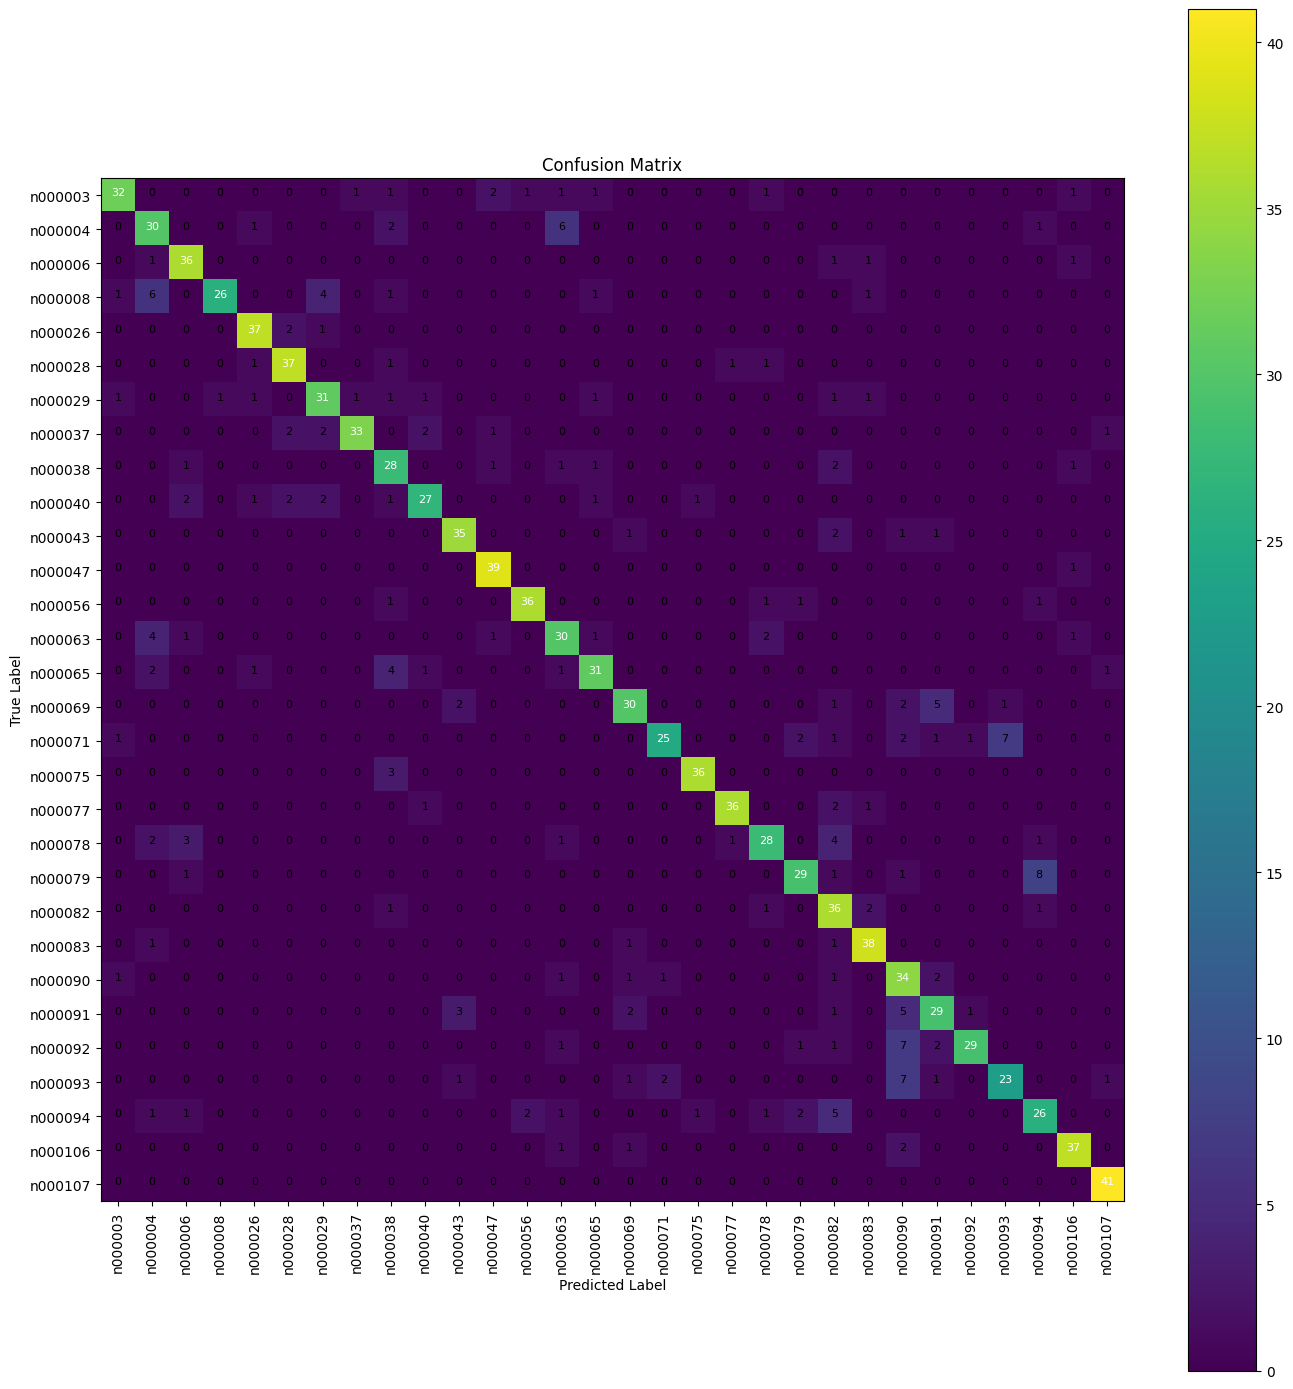

In [24]:
# =========================
# FULL SIMPLE TEST EVALUATION (NO F1, NO SUPPORT)
# =========================

import json
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import classification_report, confusion_matrix

# -------------------------
# CONFIG
# -------------------------
TEST_DIR = Path("/content/drive/MyDrive/AI_Project/experiment/split/test")

SAVE_DIR = Path("/content/drive/MyDrive/AI_Project/trained_models")
BEST_MODEL_PATH = SAVE_DIR / "vgg16_best.pth"
LABELS_PATH     = SAVE_DIR / "class_to_idx.json"

NUM_CLASSES = 30
IMG_SIZE = 224

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64 if device.type == "cuda" else 16
WORKERS = 2 if device.type == "cuda" else 0
PIN_MEMORY = (device.type == "cuda")

print("Device:", device)
print("Test dir:", TEST_DIR)
print("Model:", BEST_MODEL_PATH)
print("Labels:", LABELS_PATH)

# -------------------------
# TRANSFORMS (NO AUG)
# -------------------------
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

test_aug = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2(),
])

# -------------------------
# DATASET
# -------------------------
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

class FolderDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform):
        self.items = []
        self.transform = transform

        for cls, idx in class_to_idx.items():
            cls_dir = root_dir / cls
            if not cls_dir.exists():
                continue
            for p in cls_dir.rglob("*"):
                if p.suffix.lower() in IMG_EXTS:
                    self.items.append((str(p), idx))

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, y = self.items[idx]
        img = Image.open(path).convert("RGB")
        img = np.array(img)
        x = self.transform(image=img)["image"]
        return x, y

# load labels
with open(LABELS_PATH, "r", encoding="utf-8") as f:
    class_to_idx = json.load(f)

idx_to_class = {v: k for k, v in class_to_idx.items()}

test_ds = FolderDataset(TEST_DIR, class_to_idx, test_aug)
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=PIN_MEMORY
)

print("Test images:", len(test_ds))

# -------------------------
# LOAD MODEL
# -------------------------
model = models.vgg16(weights=None)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, NUM_CLASSES)
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# -------------------------
# TEST LOOP
# -------------------------
@torch.no_grad()
def test(model, loader):
    total, correct, loss_sum = 0, 0, 0.0
    all_preds, all_targets = [], []

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        loss = criterion(logits, y)

        loss_sum += loss.item() * y.size(0)
        preds = logits.argmax(dim=1)

        correct += (preds == y).sum().item()
        total += y.size(0)

        all_preds.append(preds.detach().cpu().numpy())
        all_targets.append(y.detach().cpu().numpy())

    return (
        loss_sum / total,
        correct / total,
        np.concatenate(all_targets),
        np.concatenate(all_preds)
    )

test_loss, test_acc, y_true, y_pred = test(model, test_loader)

print(f"\n✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_acc:.4f}")

# -------------------------
# CONFUSION MATRIX
# -------------------------
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix shape:", cm.shape)

# -------------------------
# PRECISION + RECALL ONLY (NO F1, NO SUPPORT)
# -------------------------
report = classification_report(
    y_true,
    y_pred,
    target_names=[idx_to_class[i] for i in range(NUM_CLASSES)],
    output_dict=True,
    zero_division=0
)

print("\n📊 Precision / Recall per class:\n")

for cls_name, metrics in report.items():
    if cls_name in ["accuracy", "macro avg", "weighted avg"]:
        continue

    precision = metrics["precision"]
    recall = metrics["recall"]

    print(f"{cls_name:20s} | Precision: {precision:.4f} | Recall: {recall:.4f}")


In [33]:
import json
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ========= 1) load idx_to_class =========
# لو class_to_idx موجود عندك في النوتبوك سيبيه، لو مش موجود هيتقرأ من الملف
if "class_to_idx" not in globals():
    with open(LABELS_PATH, "r", encoding="utf-8") as f:
        class_to_idx = json.load(f)
    class_to_idx = {k: int(v) for k, v in class_to_idx.items()}

idx_to_class = {v: k for k, v in class_to_idx.items()}

# ========= 2) preprocess =========
infer_aug = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD, max_pixel_value=255.0),
    ToTensorV2(),
])

def _prep(img_path):
    img = Image.open(img_path).convert("RGB")
    orig = np.array(img)  # RGB
    x = infer_aug(image=orig)["image"].unsqueeze(0)  # [1,3,224,224]
    return x, orig

# ========= 3) function: predict + show image + show heatmap only =========
def predict_and_gradcam_heatmap(img_path: str, conv_layer_index: int = 28):
    model.eval()

    # حل مشكلة inplace ReLU مع Grad-CAM
    for layer in model.features:
        if isinstance(layer, torch.nn.ReLU):
            layer.inplace = False

    x, orig_rgb = _prep(img_path)
    x = x.to(device)

    # ---- Prediction ----
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)
        conf, pred_idx = probs.max(dim=1)

    pred_idx = int(pred_idx.item())
    conf = float(conf.item())
    pred_class = idx_to_class[pred_idx]

    print("===================================")
    print(f"🖼️ Image: {img_path}")
    print(f"🔮 Predicted class: {pred_class}")
    print(f"📊 Confidence: {conf*100:.2f}%")
    print("===================================")

    # عرض الصورة الأصلية فقط
    plt.figure(figsize=(5,5))
    plt.imshow(orig_rgb)
    plt.title(f"Image (Pred: {pred_class})")
    plt.axis("off")
    plt.show()

    # ---- Grad-CAM Heatmap ONLY ----
    target_layer = model.features[conv_layer_index]

    activations = None
    gradients = None

    def _store_grad(g):
        nonlocal gradients
        gradients = g

    def forward_hook(module, inp, out):
        nonlocal activations
        activations = out
        out.register_hook(_store_grad)

    h = target_layer.register_forward_hook(forward_hook)

    logits2 = model(x)                 # forward مع hooks
    score = logits2[0, pred_idx]       # نفس الكلاس المتوقع
    model.zero_grad(set_to_none=True)
    score.backward()

    h.remove()

    # compute heatmap
    weights = gradients.mean(dim=(2, 3), keepdim=True)            # [1,C,1,1]
    cam = (weights * activations).sum(dim=1, keepdim=True)        # [1,1,h,w]
    cam = torch.relu(cam)

    cam = cam.squeeze().detach().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    H, W = orig_rgb.shape[:2]
    cam_resized = cv2.resize(cam, (W, H))

    # عرض heatmap لوحدها (ده اللي بيبين هو بيركز على ايه)
    plt.figure(figsize=(5,5))
    plt.imshow(cam_resized, cmap="jet")
    plt.title("Grad-CAM Heatmap (focus areas)")
    plt.axis("off")
    plt.show()

    return pred_class, conf, cam_resized




🖼️ Image: /content/drive/MyDrive/AI_Project/experiment/split/test/n000006/0011_01.jpg
🔮 Predicted class: n000006
📊 Confidence: 96.81%


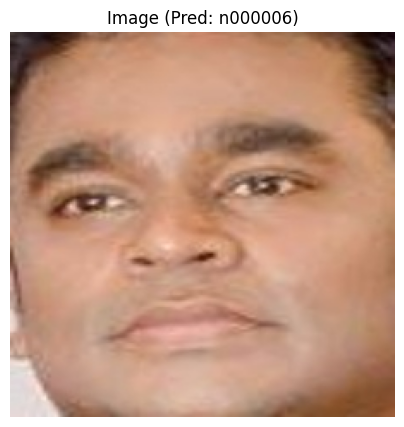

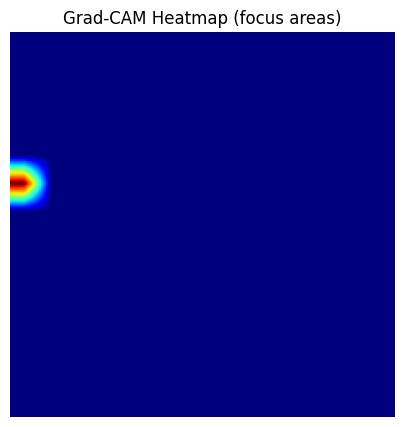

('n000006',
 0.9680595993995667,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [34]:
img_path = "/content/drive/MyDrive/AI_Project/experiment/split/test/n000006/0011_01.jpg"
predict_and_gradcam_heatmap(img_path)
